In [4]:
import pandas as pd
import numpy as np
data= pd.read_csv('IMDB Dataset.csv')
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})
data['review'] = data['review'].str.replace('<br />', ' ') 




In [5]:
data.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming t...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [6]:
print(data.shape)
data.isnull().sum() # missing values 

print(data.duplicated().sum())  # duplicate values
# data.remove_duplicates(inplace=True)
# print(data.duplicated().sum())





(50000, 2)
418


 Sentiment distribution-------->>>>>

In [7]:
print(f"\n Sentiment distribution")
print(data['sentiment'].value_counts())



 Sentiment distribution
sentiment
1    25000
0    25000
Name: count, dtype: int64


review lenth analyses ------------>>>>>>

In [8]:
print(f'\n review length stats')
data['Review_length']=data['review'].str.len()
print(data['Review_length'].describe())


 review length stats
count    50000.000000
mean      1289.236220
std        974.203334
min         32.000000
25%        691.000000
50%        957.000000
75%       1563.000000
max      13604.000000
Name: Review_length, dtype: float64


Data preprcessing------------>>>>

In [9]:
import re
def clean_text(text):
    """Clean and preprocess text data"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespaces
    text = ' '.join(text.split())
    
    return text


In [10]:
# clean the review
data['cleaned_Review']= data['review'].apply(clean_text)

# remove empty review
data=data[data['cleaned_Review'].str.len()>0]

#Encode sentiment labels(if they r texts)
if data['sentiment'].dtype=='object':
    sentiment_mapping={
        'positive':1,'negative':0,
        'pos':1,'neg':0,
        '1':1,'0':0
    }
    data['sentiment']=data['sentiment'].str.lower().map(sentiment_mapping)

# Remove any rows with unmapped sentiments
data=data.dropna(subset=['sentiment']) 

print(f'\n after preprocess:{data.shape[0]} reviews')
print(f'\n semtiment distribution after preprocess :')
print(data['sentiment'].value_counts())


 after preprocess:50000 reviews

 semtiment distribution after preprocess :
sentiment
1    25000
0    25000
Name: count, dtype: int64


feature engineering------->>>>>>>>>

In [11]:

print("ceating Features...")
    #text based features-->
data['word_count']=data['cleaned_Review'].str.split().str.len()
data['char_count']=data['cleaned_Review'].str.len()
data['avg_word_length']=data['char_count']/ data['word_count']
    
     # Sentiment words count (simple approach)
positive_words = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic', 'love']
negative_words = ['bad', 'terrible', 'awful', 'horrible', 'hate', 'worst', 'disappointing']
    
data['positive_word_count']=data['cleaned_Review'].apply(
        lambda x:sum([word in x.lower() for word in positive_words])
    )
data['negative_word_count']= data['cleaned_Review'].apply(
        lambda x:sum([word in x.lower() for word in negative_words])
    )
    
   



ceating Features...


Model training ------->>>>


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import re
import string
#from wordcloud import WordCloud
import streamlit as st
import pickle
import warnings
warnings.filterwarnings('ignore')

In [13]:
# =====================================================
# 5. TRAIN-TEST SPLIT
# =====================================================

print(f"\n🔄 Performing Train-Test Split...")

# Extract features (X) and target (y)
X = data['review']  # Features (text reviews)
y = data['sentiment']  # Target (0 or 1)

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,          # 20% for testing, 80% for training
    random_state=42,        # For reproducible results
    stratify=y              # Maintain same proportion of positive/negative in both sets
)




🔄 Performing Train-Test Split...
Features (X) shape: (50000,)
Target (y) shape: (50000,)


In [14]:
# =====================================================
# 6. DISPLAY SPLIT RESULTS
# =====================================================

print(f"\nTrain-Test Split Completed!")
print(f"{'='*50}")

print(f"Training set:")
print(f"  - Size: {len(X_train)} samples ({len(X_train)/len(data)*100:.1f}%)")
print(f"  - Positive reviews: {sum(y_train)} ({sum(y_train)/len(y_train)*100:.1f}%)")
print(f"  - Negative reviews: {len(y_train)-sum(y_train)} ({(len(y_train)-sum(y_train))/len(y_train)*100:.1f}%)")

print(f"\nTesting set:")
print(f"  - Size: {len(X_test)} samples ({len(X_test)/len(data)*100:.1f}%)")
print(f"  - Positive reviews: {sum(y_test)} ({sum(y_test)/len(y_test)*100:.1f}%)")
print(f"  - Negative reviews: {len(y_test)-sum(y_test)} ({(len(y_test)-sum(y_test))/len(y_test)*100:.1f}%)")


Train-Test Split Completed!
Training set:
  - Size: 40000 samples (80.0%)
  - Positive reviews: 20000 (50.0%)
  - Negative reviews: 20000 (50.0%)

Testing set:
  - Size: 10000 samples (20.0%)
  - Positive reviews: 5000 (50.0%)
  - Negative reviews: 5000 (50.0%)


In [15]:

print("🤖 Training Models...")
print("=" * 50)

# Define models directly
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Define vectorizers directly
vectorizers = {
    'TF-IDF': TfidfVectorizer(max_features=10000, stop_words='english'),
    'Count': CountVectorizer(max_features=10000, stop_words='english')
}

# Initialize results list
results = []

# Initialize variables to store best model
best_model = None
best_vectorizer = None

# Training loop - no functions needed
for vec_name, vectorizer in vectorizers.items():
    print(f"\n--- Using {vec_name} Vectorizer ---")
    
    # Fit vectorizer and transform data
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    for model_name, model in models.items():
        # Train model
        model.fit(X_train_vec, y_train)  # Make sure to use y_train, not Y_train
        
        # Predict
        y_pred = model.predict(X_test_vec)
        accuracy = accuracy_score(y_test, y_pred)  # Make sure to use y_test, not Y_test
        
        # Store results
        results.append({
            'Vectorizer': vec_name,
            'Model': model_name,
            'Accuracy': accuracy
        })
        
        # Store best model (TF-IDF + Logistic Regression)
        if vec_name == 'TF-IDF' and model_name == 'Logistic Regression':
            best_model = model
            best_vectorizer = vectorizer
        
        # Print results immediately
        print(f"  {model_name}: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Create results DataFrame
results_df = pd.DataFrame(results)

# Display results nicely
print("\n" + "=" * 50)
print("📊 MODEL PERFORMANCE SUMMARY")
print("=" * 50)
print(results_df.to_string(index=False))

# Find and display best performing model
best_result = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\n BEST MODEL: {best_result['Model']} with {best_result['Vectorizer']}")
print(f"   Accuracy: {best_result['Accuracy']:.4f} ({best_result['Accuracy']*100:.2f}%)")

# Display the results DataFrame as a table
print(f"\n📊 Results DataFrame:")
display(results_df)  # table

# Show additional statistics
print(f"\n📈 DETAILED STATISTICS:")
print(f"Total model combinations tested: {len(results_df)}")
print(f"Average accuracy across all models: {results_df['Accuracy'].mean():.4f}")
print(f"Best accuracy achieved: {results_df['Accuracy'].max():.4f}")
print(f"Worst accuracy: {results_df['Accuracy'].min():.4f}")

# Create a pivot table for better visualization
print(f"\n📋 ACCURACY COMPARISON TABLE:")
pivot_results = results_df.pivot(index='Model', columns='Vectorizer', values='Accuracy')
print(pivot_results.round(4))

# Show which vectorizer performs better on average
print(f"\n🔍 VECTORIZER COMPARISON:")
vectorizer_avg = results_df.groupby('Vectorizer')['Accuracy'].mean()
print(vectorizer_avg.round(4))

print(f"\n🔍 MODEL COMPARISON:")
model_avg = results_df.groupby('Model')['Accuracy'].mean()
print(model_avg.round(4))

🤖 Training Models...

--- Using TF-IDF Vectorizer ---
  Naive Bayes: 0.8577 (85.77%)
  Logistic Regression: 0.8948 (89.48%)
  Random Forest: 0.8531 (85.31%)

--- Using Count Vectorizer ---
  Naive Bayes: 0.8495 (84.95%)
  Logistic Regression: 0.8769 (87.69%)
  Random Forest: 0.8532 (85.32%)

📊 MODEL PERFORMANCE SUMMARY
Vectorizer               Model  Accuracy
    TF-IDF         Naive Bayes    0.8577
    TF-IDF Logistic Regression    0.8948
    TF-IDF       Random Forest    0.8531
     Count         Naive Bayes    0.8495
     Count Logistic Regression    0.8769
     Count       Random Forest    0.8532

 BEST MODEL: Logistic Regression with TF-IDF
   Accuracy: 0.8948 (89.48%)

📊 Results DataFrame:


,Vectorizer,Model,Accuracy
0,TF-IDF,Naive Bayes,0.8577
1,TF-IDF,Logistic Regression,0.8948
2,TF-IDF,Random Forest,0.8531
3,Count,Naive Bayes,0.8495
4,Count,Logistic Regression,0.8769
5,Count,Random Forest,0.8532



📈 DETAILED STATISTICS:
Total model combinations tested: 6
Average accuracy across all models: 0.8642
Best accuracy achieved: 0.8948
Worst accuracy: 0.8495

📋 ACCURACY COMPARISON TABLE:
Vectorizer            Count  TF-IDF
Model                              
Logistic Regression  0.8769  0.8948
Naive Bayes          0.8495  0.8577
Random Forest        0.8532  0.8531

🔍 VECTORIZER COMPARISON:
Vectorizer
Count     0.8599
TF-IDF    0.8685
Name: Accuracy, dtype: float64

🔍 MODEL COMPARISON:
Model
Logistic Regression    0.8858
Naive Bayes            0.8536
Random Forest          0.8532
Name: Accuracy, dtype: float64


In [16]:
def predict(self, text):
        """Predict sentiment for new text"""
        if 'best' not in self.models or 'best' not in self.vectorizers:
            print("❌ Error: Model not trained yet! Please run train_models() first.")
            return None
        
        cleaned_text = clean_text(text)
        text_vec = self.vectorizers['best'].transform([cleaned_text])
        prediction = self.models['best'].predict(text_vec)[0]
        probability = self.models['best'].predict_proba(text_vec)[0]
        
        result = {
            'prediction': 'Positive' if prediction == 1 else 'Negative',
            'confidence': max(probability),
            'probabilities': {
                'Negative': probability[0],
                'Positive': probability[1]
            }
        }
        
        # Print the prediction nicely
        print(f"📝 Review: '{text[:60]}{'...' if len(text) > 60 else ''}'")
        print(f"🎯 Prediction: {result['prediction']}")
        print(f"💯 Confidence: {result['confidence']:.2%}")
        print(f"📊 Probabilities:")
        print(f"   Negative: {result['probabilities']['Negative']:.2%}")
        print(f"   Positive: {result['probabilities']['Positive']:.2%}")
        
        return result


In [17]:
def save_with_pickle(model, vectorizer, filename_prefix='sentiment'):
    """Save model and vectorizer using pickle"""
    print("💾 Saving with Pickle...")
    
    # Save the complete analyzer object (recommended)
    model_data = {
        'model': model,
        'vectorizer': vectorizer,
        'metadata': {
            'created_date': pd.Timestamp.now(),
            'model_type': str(type(model).__name__),
            'vectorizer_type': str(type(vectorizer).__name__)
        }
    }
    
    with open(f'{filename_prefix}_model.pkl', 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"✅ Model saved as '{filename_prefix}_model.pkl'")
    


In [18]:
# Save the best model (TF-IDF + Logistic Regression)
save_with_pickle(best_model, best_vectorizer, 'sentiment')

💾 Saving with Pickle...
✅ Model saved as 'sentiment_model.pkl'


Classification Report:
              precision    recall  f1-score   support

    Negative       0.85      0.86      0.85      5000
    Positive       0.86      0.85      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



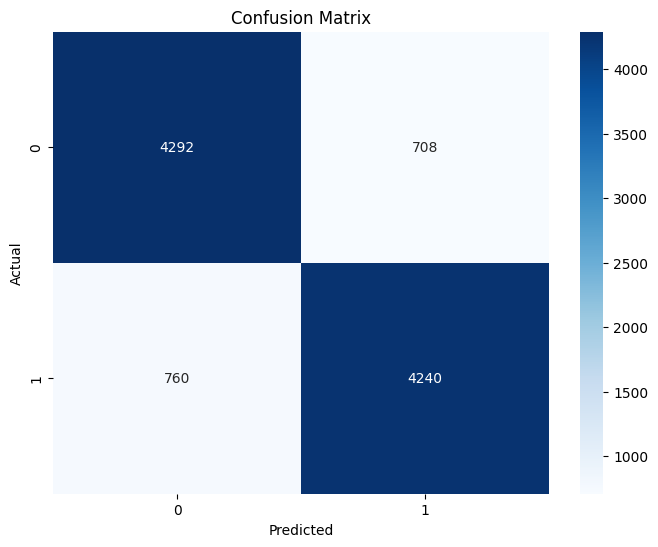

In [19]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
print("\n📊 Top Important Features (Words):")

# Get feature names and coefficients
feature_names = best_vectorizer.get_feature_names_out()
coefficients = best_model.coef_[0]

# Create feature importance dataframe
feature_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients
}).sort_values('coefficient')

# Top 10 most negative and positive features
top_negative = feature_df.head(10)
top_positive = feature_df.tail(10)

plt.figure(figsize=(15, 6))



📊 Top Important Features (Words):


<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

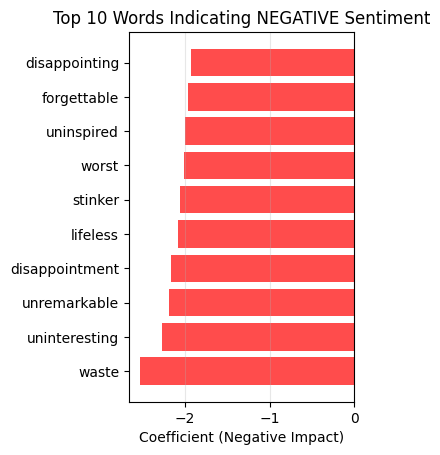

In [21]:
# Plot negative features
plt.subplot(1, 2, 1)
plt.barh(range(len(top_negative)), top_negative['coefficient'], color='red', alpha=0.7)
plt.yticks(range(len(top_negative)), top_negative['word'])
plt.xlabel('Coefficient (Negative Impact)')
plt.title('Top 10 Words Indicating NEGATIVE Sentiment')
plt.grid(axis='x', alpha=0.3)

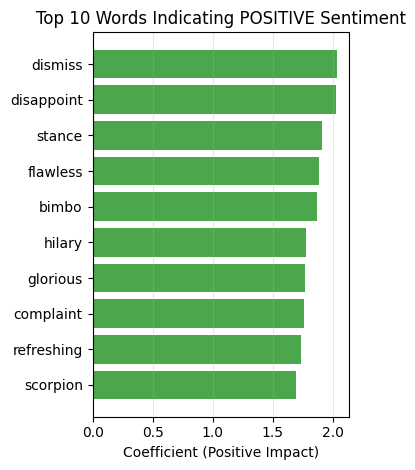

In [22]:
# Plot positive features
plt.subplot(1, 2, 2)
plt.barh(range(len(top_positive)), top_positive['coefficient'], color='green', alpha=0.7)
plt.yticks(range(len(top_positive)), top_positive['word'])
plt.xlabel('Coefficient (Positive Impact)')
plt.title('Top 10 Words Indicating POSITIVE Sentiment')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Create simple features for Weka
weka_features = pd.DataFrame({
    'word_count': X_test.str.split().str.len(),
    'char_count': X_test.str.len(),
    'exclamation_count': X_test.str.count('!'),
    'question_count': X_test.str.count('\\?'),  # Escaped question mark
    'positive_words': X_test.str.lower().str.count('good|great|excellent|amazing|wonderful'),
    'negative_words': X_test.str.lower().str.count('bad|terrible|awful|horrible|worst'),
    'sentiment': y_test.map({1: 'positive', 0: 'negative'})
})

# Save to CSV for Weka
weka_features.to_csv('sentiment_for_weka.csv', index=False)
print("✅ Saved 'sentiment_for_weka.csv' - Ready for Weka!")
print("📋 Features exported: word_count, char_count, exclamation_count, question_count, positive_words, negative_words")




✅ Saved 'sentiment_for_weka.csv' - Ready for Weka!
📋 Features exported: word_count, char_count, exclamation_count, question_count, positive_words, negative_words
